# Assignment 4: Image Super-Resolution

In [0]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import warnings
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, DataLoader

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# For work with google colab.
from google.colab import drive
import nltk
nltk.download('punkt')
drive.mount('/content/drive/')
os.chdir('drive/My Drive/Y-Data/Deep Learning/assignment4/')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Stage 1

### Create dataset

We would like to create a dataset and a data-loader for the training of super-resolution network.
We will use self-supervision to create our dataset.

* Create a dataset with images of 3 different sizes:
X - 72x72x3 y_mid – 144x144x3 y_large – 288x288x3
You may choose to either persist these different sizes to disk or create them on-the-fly within your data loader


* Split them into training and validating our model, for simplicity, we will use the first 1000 images (~20%) for validation and the rest for training. (note you should have 5011 images in total but are welcome to add more if you wish to)

Note – I strongly recommend to only work on a sample of the data to make the process of loading and processing faster. This is a good practice for quick development of the loading pipeline and initial model creation. Once everything is working the way we expect it to work, we can increase the number of images we load and be sure that the process runs smoothly.

* Next, present few images so that we can compare the training with our desired labels, this process is good for verifying that

In [58]:
# Directory with raw images downloaded.
IMG_DIR = 'small-set/'
# Directory with images of 3 different sizes: small, medium, large
DATASET_DIR = 'dataset/'

SMALL_IMG_SIZE = 72
MEDIUM_IMG_SIZE = 144
LARGE_IMG_SIZE = 288

image_sizes = [SMALL_IMG_SIZE, MEDIUM_IMG_SIZE, LARGE_IMG_SIZE]

test_size = 0.2

path_to_name = lambda f: os.path.splitext(os.path.basename(f))[0]
img_list = [path_to_name(img_path) for img_path in glob.glob(IMG_DIR + '*.jpg')]
len(img_list)

42

In [0]:
def write_dataset_image(img, img_name, img_size):
  out_img = cv2.resize(img, (img_size, img_size))
  out_path = DATASET_DIR + img_name + '_' + str(img_size) + '.jpg'
  cv2.imwrite(out_path, out_img)

def process_image(img_name):
  img = cv2.imread(IMG_DIR + img_name + '.jpg')
  for img_size in image_sizes:
    write_dataset_image(img, img_name, img_size)

for i in img_list:
    process_image(i)

In [0]:
class DatasetFromList(Dataset):
  def __init__(self, img_list, img_size):
    super(DatasetFromList, self).__init__()
    self.source = [DATASET_DIR + img_name + '_' + str(SMALL_IMG_SIZE) + '.jpg' for img_name in img_list]
    self.target = [DATASET_DIR + img_name + '_' + str(img_size) + '.jpg' for img_name in img_list]

  def __getitem__(self, index):
    source = cv2.imread(self.source[index])
    target = cv2.imread(self.target[index])
    return source, target

  def __len__(self):
    return len(self.source)

train_set, test_set = train_test_split(img_list, test_size=0.2)

train_med = DatasetFromList(train_set, MEDIUM_IMG_SIZE)
train_large = DatasetFromList(train_set, LARGE_IMG_SIZE)

test_med = DatasetFromList(test_set, MEDIUM_IMG_SIZE)
test_large = DatasetFromList(test_set, LARGE_IMG_SIZE)

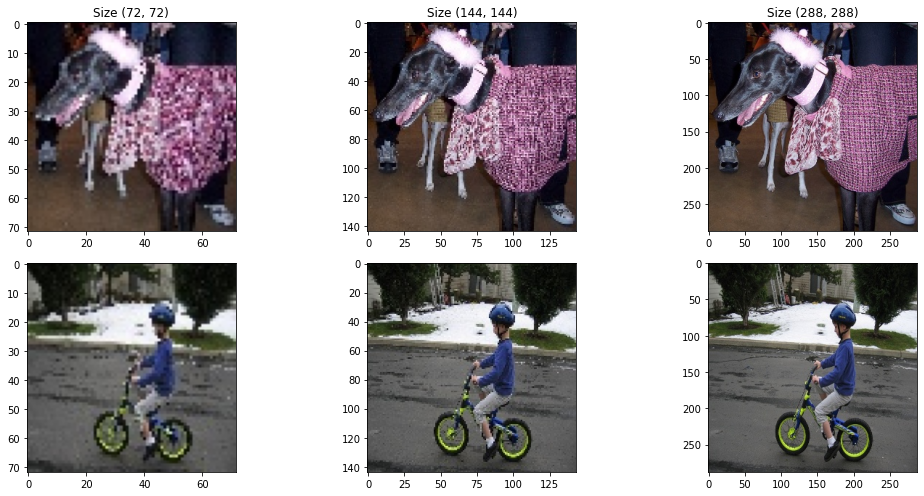

In [75]:
def plot_image(ax, row_idx, img_name):
  for col_idx, img_size in enumerate(image_sizes):
    img = cv2.imread(DATASET_DIR + img_name + '_' + str(img_size) + '.jpg')
    ax[row_idx, col_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for row_idx, img_idx in enumerate([1, 8]):
  plot_image(ax, row_idx, img_list[img_idx])
for col, img_size in zip(ax[0], image_sizes):
  col.set_title('Size ({:d}, {:d})'.format(img_size, img_size))
fig.tight_layout()
plt.show()

## Stage 2

### Initial Model

In [0]:
class Net(nn.Module):
  def __init__(self, upscale_factor):
    super(Net, self).__init__()

    ???

    self._initialize_weights()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.relu(self.upsampling(x))
    x = self.relu(self.conv3(x))
    return x

  def _initialize_weights(self):
    init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.upsampling.weight, init.calculate_gain('relu'))
    init.orthogonal_(self.conv3.weight)

In [0]:
n_threads = 4
batch_size = 24
test_batch_size = 10
upscale_factor = int(128/72)
lr = 10e-5
n_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('===> Loading datasets')
training_data_loader = DataLoader(dataset=train_med, num_workers=n_threads, batch_size=batch_size, shuffle=True)
testing_data_loader = DataLoader(dataset=test_med, num_workers=n_threads, batch_size=test_batch_size, shuffle=False)

print('===> Building model')
model = Net(upscale_factor=upscale_factor).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)


def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        source, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        loss = criterion(model(source), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

def test():
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            source, target = batch[0].to(device), batch[1].to(device)

            prediction = model(source)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


def checkpoint(epoch):
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    checkpoint(epoch)